## Exploratory Data Analysis
#### This notebook is dedicated to exploring the afrobeats playlist.

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
from sklearn.decomposition import PCA

from scipy import sparse
import plotly.express as px
import time

#### Import afrobeats playlist data

In [202]:
afrobeats = pd.read_csv('../data/afrobeats.csv')
afrobeats.head(2)

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,danceability,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0mDRuZmReEm6DquPLJlcEm,Oleku (feat. Brymo),Ice Prince,{'external_urls': {'spotify': 'https://open.sp...,1sSt1DqqqFLkPwfrqafVyn,54,"['afro dancehall', 'afropop', 'azontobeats', '...",Oleku (feat. Brymo),51,0.544,...,0.751,162.112,audio_features,0mDRuZmReEm6DquPLJlcEm,spotify:track:0mDRuZmReEm6DquPLJlcEm,https://api.spotify.com/v1/tracks/0mDRuZmReEm6...,https://api.spotify.com/v1/audio-analysis/0mDR...,291364.0,5.0,afrobeats
1,1tvi8tv0eykhNcV1WtaIqO,Move Back,5five,{'external_urls': {'spotify': 'https://open.sp...,37zb1JQnDV9dRLatrASEj1,29,"['afro dancehall', 'azonto', 'hiplife']",Move Back,45,0.793,...,0.793,125.032,audio_features,1tvi8tv0eykhNcV1WtaIqO,spotify:track:1tvi8tv0eykhNcV1WtaIqO,https://api.spotify.com/v1/tracks/1tvi8tv0eykh...,https://api.spotify.com/v1/audio-analysis/1tvi...,237107.0,4.0,afrobeats


#### Set the features we will use for EDA

In [203]:
features = ['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']

#### Create a dataframe of the features we will use for analysis

In [204]:
df = afrobeats[features].copy()

In [205]:
df['track_name'] = afrobeats['track_name']

In [212]:
df.head()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_name,clusters
0,0.544,0.730,-4.299,0.0,0.1440,0.344,0.000001,0.140,0.751,162.112,Oleku (feat. Brymo),0
1,0.793,0.734,-9.252,0.0,0.0981,0.323,0.000002,0.777,0.793,125.032,Move Back,1
2,0.879,0.737,-5.412,1.0,0.0421,0.525,0.005760,0.268,0.967,119.990,Pakurumo,0
3,0.697,0.841,-6.782,1.0,0.2710,0.224,0.000000,0.336,0.808,103.070,The Matter (feat. Wizkid),0
4,0.520,0.717,-3.006,0.0,0.3890,0.116,0.000000,0.249,0.704,135.550,Slow Down (feat. Wiz Kid),0


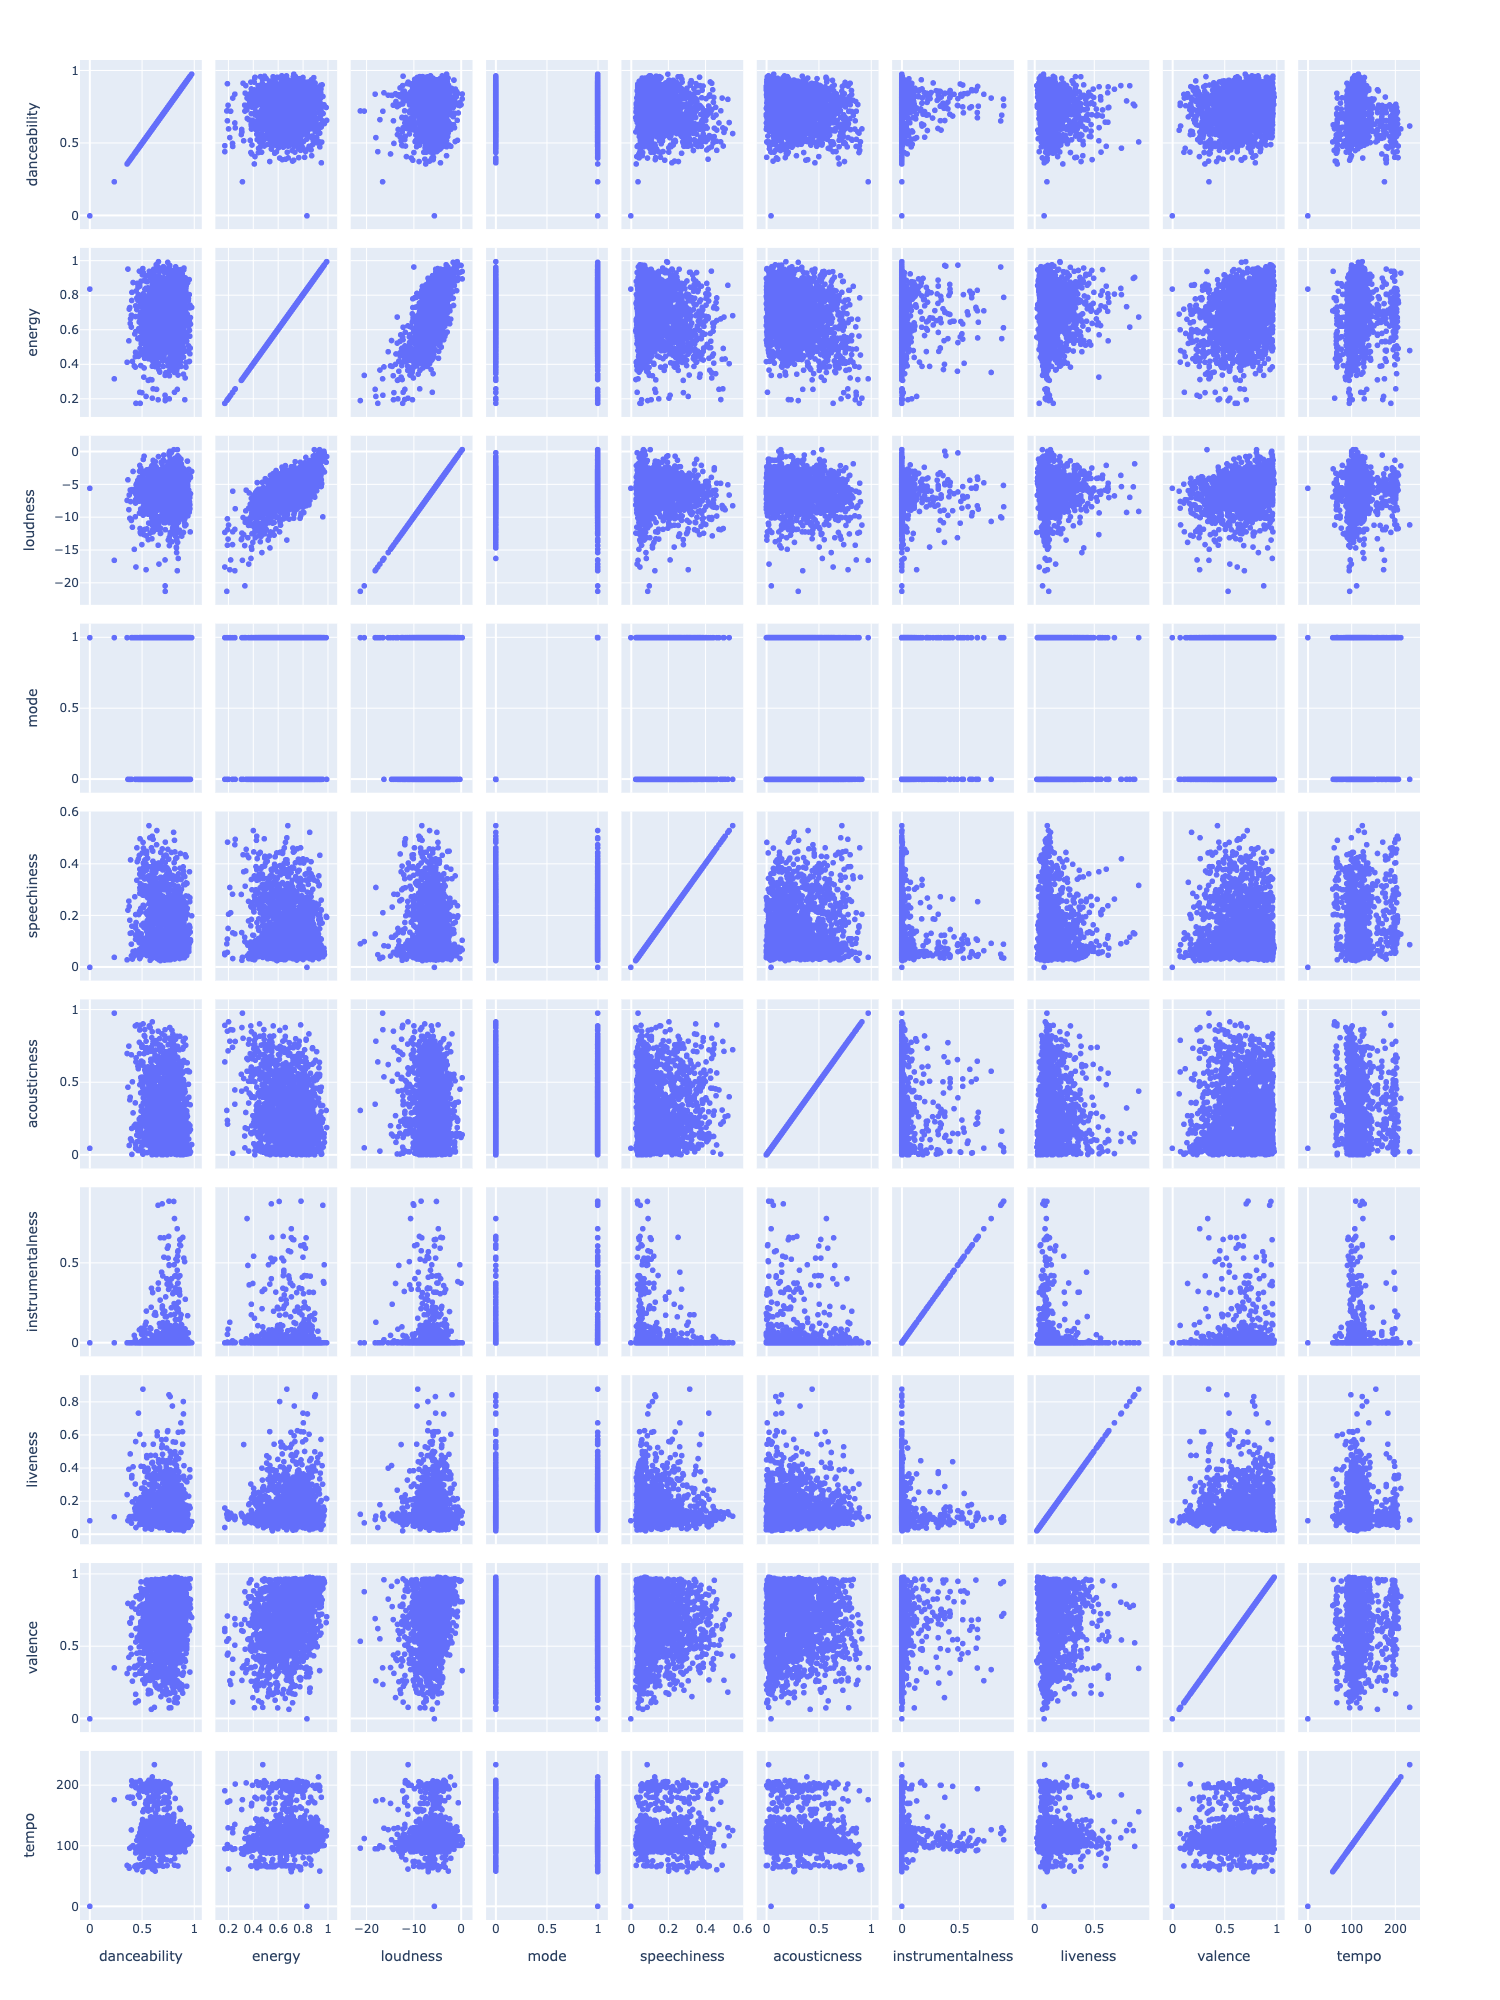

In [207]:

fig = px.scatter_matrix(df,
    dimensions=features, hover_name='track_name', height=2000)
fig.show()

#### Loudness, Energy, Danceability

Loudness, energy, and danceability all have strong relationships. I will anaylse the three features below

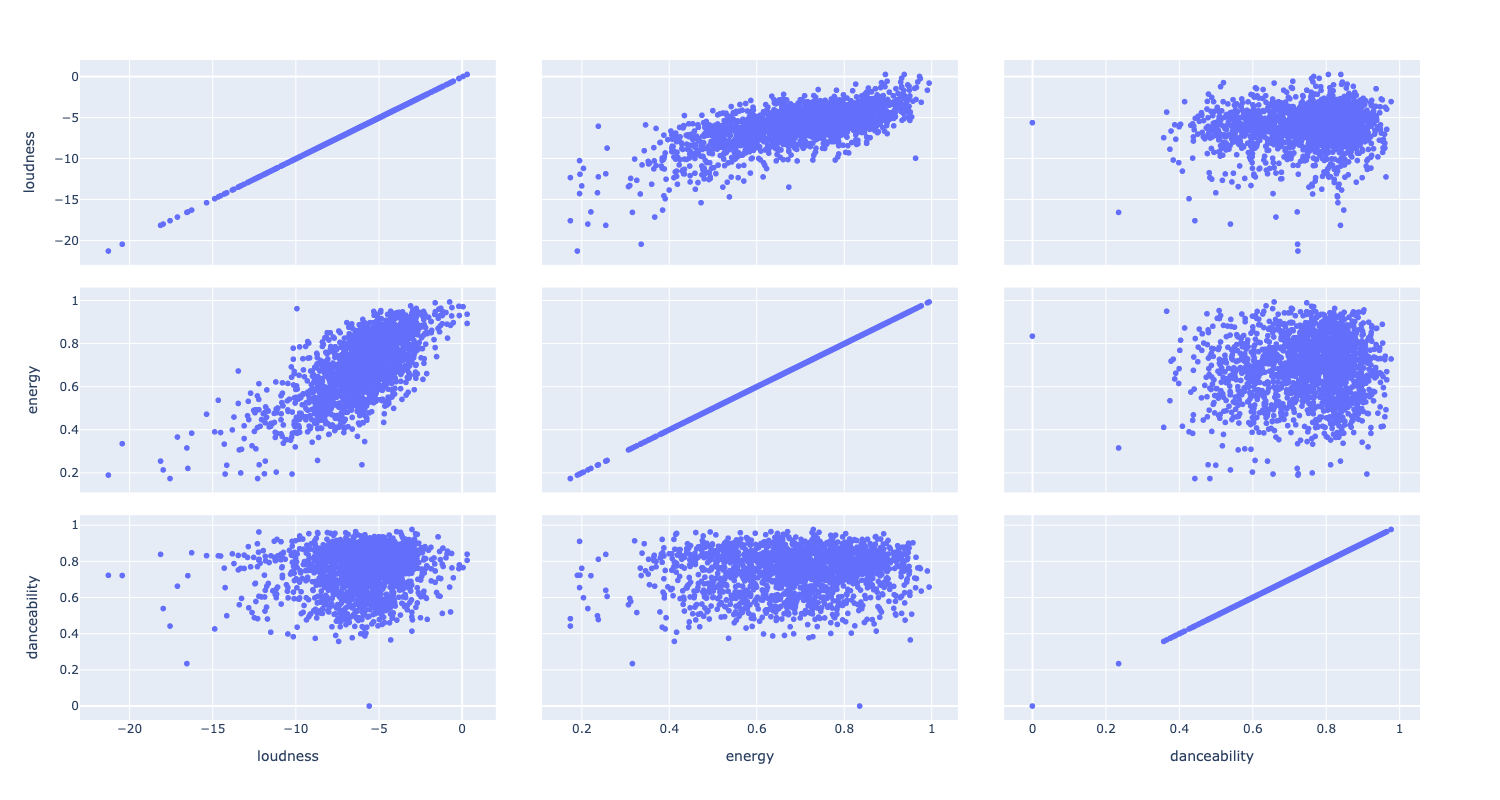

In [208]:
fig = px.scatter_matrix(df,
    dimensions=['loudness', 'energy', 'danceability'],hover_name='track_name', height=800)
fig.show()

#### Visualize the clusters

Using kmeans algorithm, let's create clusters of songs with loudness, energy, and danceability as features.

This will help us create sub-genres based on the overall song energy, loudness and danceability

In [223]:
def cluster_plots(df, k):
    #scale features
    ss = StandardScaler()
    df_ss = ss.fit_transform(df) 
    
    #instantiate kmeans
    km = KMeans(n_clusters=k)
    km.fit(df_ss)
    
    #add labels to the dataframe
    labels = km.labels_
    return labels

#### Using Silhouette score and inertia, evaluate the best value for k

#### Silhoutte Score

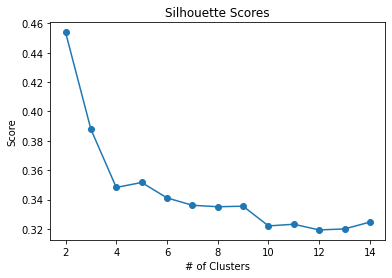

In [236]:
silhouette_list = []

for k in range(2, 15):
    #scale features
    ss = StandardScaler()
    df_ss = ss.fit_transform(df[['loudness','energy']]) 
    
    #kmeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_ss)
    silhouette_list.append(silhouette_score(df_ss, kmeans.labels_))

plt.plot(range(2, 15), silhouette_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores');

#### Inertia (Elbow plot)

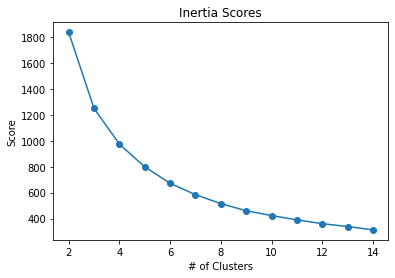

In [237]:
inertia_list = []

for k in range(2, 15):   
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_ss)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(2, 15), inertia_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

k = 6, seems to be a good number for clustering

#### Generate and create a clusters column

In [240]:
df['clusters'] = cluster_plots(df[['loudness','energy']],4)

In [244]:
df['clusters'].unique()

array([1, 2, 0, 3], dtype=int32)

#### Using plotly to display an interactive scatter matrix

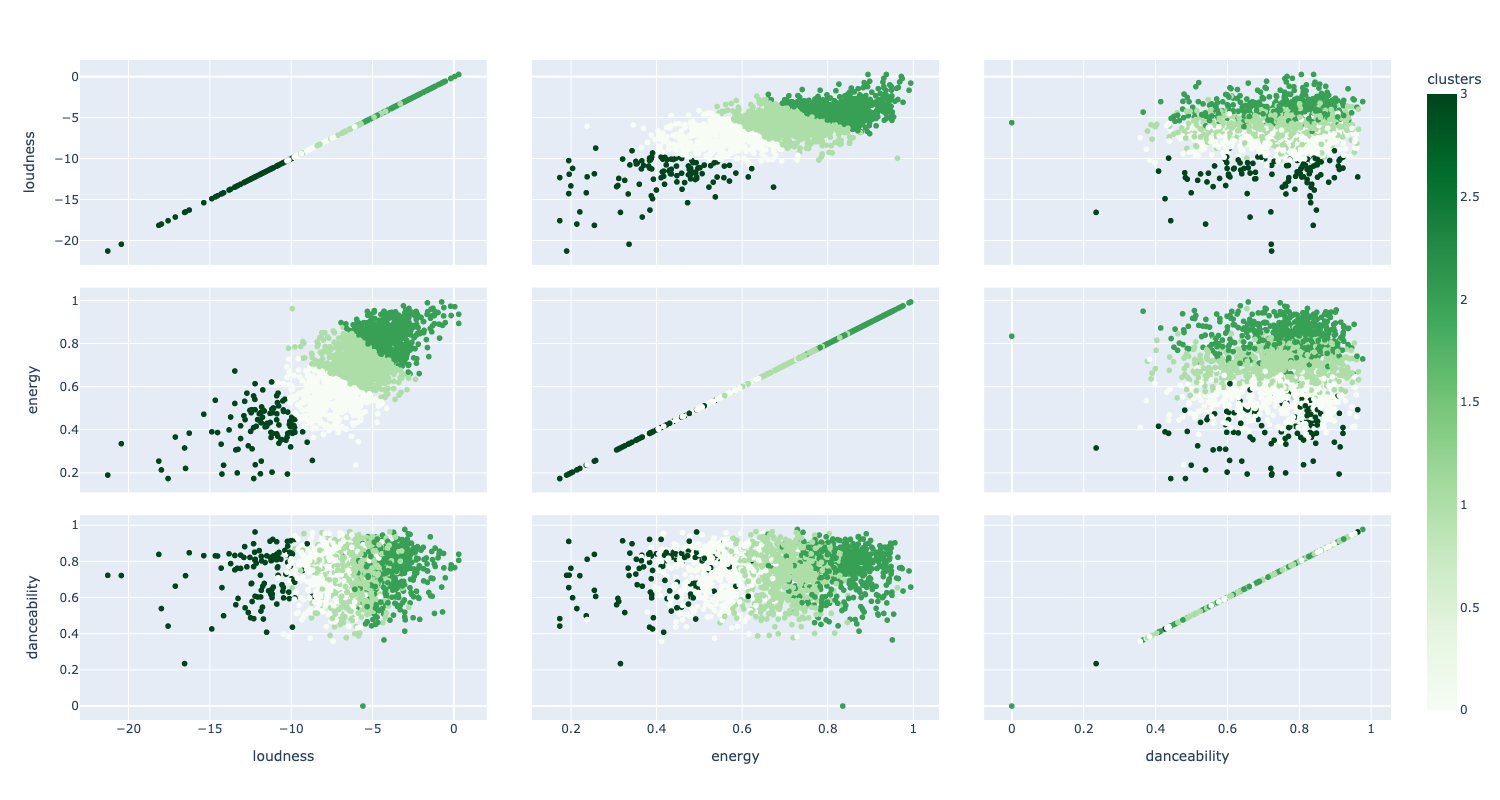

In [245]:
fig = px.scatter_matrix(df,
    dimensions=['loudness', 'energy', 'danceability'],color='clusters',color_continuous_scale='greens',hover_name='track_name', height=800)
fig.show()

#### Sort afrobeats songs by popularity

Get the top ten most popular afrobeats song

In [62]:
top_ten_songs = df.sort_values(by='track_pop',ascending=False).iloc[:10]
top_ten_songs[['track_name','artist_name']]

,track_name,artist_name
1493,Woman,Doja Cat
378,love nwantiti (ah ah ah),CKay
218,love nwantiti (feat. Dj Yo! & AX'EL) - Remix,CKay
285,One Dance,Drake
179,Peru,Fireboy DML
171,Attention,Omah Lay
279,Location (feat. Burna Boy),Dave
393,D O D O,Tayc
254,Ameno Amapiano Remix (You Wanna Bamba),Goya Menor
1400,Dégaine (feat. Damso),Aya Nakamura


In [66]:
top_ten_songs.set_index(['track_name'], inplace=True)

#### Let's analyse the features of the top ten tracks 

In [68]:
features = ['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']


In [69]:
top_ten_songs[features]

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_name,,,,,,,,,,
Woman,0.824,0.764,-4.175,0.0,0.0854,0.08880,0.002940,0.1170,0.881,107.998
love nwantiti (ah ah ah),0.727,0.739,-3.805,1.0,0.0411,0.36500,0.001370,0.1610,0.533,93.005
love nwantiti (feat. Dj Yo! & AX'EL) - Remix,0.579,0.596,-4.823,1.0,0.0561,0.43600,0.093800,0.0549,0.443,119.900
One Dance,0.792,0.625,-5.609,1.0,0.0536,0.00776,0.001800,0.3290,0.370,103.967
Peru,0.956,0.417,-7.892,0.0,0.0926,0.57200,0.000710,0.0782,0.714,108.015
Attention,0.817,0.720,-8.134,0.0,0.0809,0.17200,0.000726,0.1090,0.384,119.989
Location (feat. Burna Boy),0.812,0.496,-5.969,0.0,0.2970,0.27100,0.000000,0.0955,0.550,109.979
D O D O,0.678,0.646,-7.996,0.0,0.1120,0.30400,0.000405,0.1540,0.582,98.816
Ameno Amapiano Remix (You Wanna Bamba),0.807,0.898,-5.837,0.0,0.0393,0.18800,0.000395,0.0824,0.743,112.998


In [70]:
df.sort_values(by='artist_popularity',ascending=False).iloc[:10]

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,danceability,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
285,1zi7xx7UVEFkmKfv06H8x0,One Dance,Drake,{'external_urls': {'spotify': 'https://open.sp...,3TVXtAsR1Inumwj472S9r4,98,"['canadian hip hop', 'canadian pop', 'hip hop'...",Views,90,0.792,...,0.370,103.967,audio_features,1zi7xx7UVEFkmKfv06H8x0,spotify:track:1zi7xx7UVEFkmKfv06H8x0,https://api.spotify.com/v1/tracks/1zi7xx7UVEFk...,https://api.spotify.com/v1/audio-analysis/1zi7...,173987.0,4.0,afrobeats
213,08XWh5c0BMyD1nKVxxl91z,Fountains (with Tems),Drake,{'external_urls': {'spotify': 'https://open.sp...,3TVXtAsR1Inumwj472S9r4,98,"['canadian hip hop', 'canadian pop', 'hip hop'...",Certified Lover Boy,77,0.843,...,0.689,100.053,audio_features,08XWh5c0BMyD1nKVxxl91z,spotify:track:08XWh5c0BMyD1nKVxxl91z,https://api.spotify.com/v1/tracks/08XWh5c0BMyD...,https://api.spotify.com/v1/audio-analysis/08XW...,192418.0,4.0,afrobeats
501,79fxhzh6O3mJjsKQpIjTVy,Loved By You (feat. Burna Boy),Justin Bieber,{'external_urls': {'spotify': 'https://open.sp...,1uNFoZAHBGtllmzznpCI3s,96,"['canadian pop', 'pop']",Justice,43,0.782,...,0.633,100.995,audio_features,79fxhzh6O3mJjsKQpIjTVy,spotify:track:79fxhzh6O3mJjsKQpIjTVy,https://api.spotify.com/v1/tracks/79fxhzh6O3mJ...,https://api.spotify.com/v1/audio-analysis/79fx...,159250.0,4.0,afrobeats
465,6lUpRCvUGvAymNGJzVywN8,Peaches (Masterkraft Remix) feat. Alpha P & Om...,Justin Bieber,{'external_urls': {'spotify': 'https://open.sp...,1uNFoZAHBGtllmzznpCI3s,96,"['canadian pop', 'pop']",Peaches (Masterkraft Remix),51,0.597,...,0.553,123.967,audio_features,6lUpRCvUGvAymNGJzVywN8,spotify:track:6lUpRCvUGvAymNGJzVywN8,https://api.spotify.com/v1/tracks/6lUpRCvUGvAy...,https://api.spotify.com/v1/audio-analysis/6lUp...,194896.0,5.0,afrobeats
1493,6Uj1ctrBOjOas8xZXGqKk4,Woman,Doja Cat,{'external_urls': {'spotify': 'https://open.sp...,5cj0lLjcoR7YOSnhnX0Po5,94,"['dance pop', 'pop']",Planet Her,97,0.824,...,0.881,107.998,audio_features,6Uj1ctrBOjOas8xZXGqKk4,spotify:track:6Uj1ctrBOjOas8xZXGqKk4,https://api.spotify.com/v1/tracks/6Uj1ctrBOjOa...,https://api.spotify.com/v1/audio-analysis/6Uj1...,172627.0,4.0,afrobeats
563,04QTmCTsaVjcGaoxj8rSjE,Know Your Worth (feat. Davido & Tems),Khalid,{'external_urls': {'spotify': 'https://open.sp...,6LuN9FCkKOj5PcnpouEgny,90,"['pop', 'pop r&b']",Know Your Worth (feat. Davido & Tems),68,0.819,...,0.665,102.995,audio_features,04QTmCTsaVjcGaoxj8rSjE,spotify:track:04QTmCTsaVjcGaoxj8rSjE,https://api.spotify.com/v1/tracks/04QTmCTsaVjc...,https://api.spotify.com/v1/audio-analysis/04QT...,191068.0,4.0,afrobeats
562,434baZo99jvOx6y6oFeQZQ,Tsunami (feat. Davido),Pop Smoke,{'external_urls': {'spotify': 'https://open.sp...,0eDvMgVFoNV3TpwtrVCoTj,88,['brooklyn drill'],Shoot For The Stars Aim For The Moon (Deluxe),53,0.696,...,0.812,115.019,audio_features,434baZo99jvOx6y6oFeQZQ,spotify:track:434baZo99jvOx6y6oFeQZQ,https://api.spotify.com/v1/tracks/434baZo99jvO...,https://api.spotify.com/v1/audio-analysis/434b...,208695.0,4.0,afrobeats
385,33z5crv3IO5U2BOi8xod92,Something New (feat. Ty Dolla $ign),Wiz Khalifa,{'external_urls': {'spotify': 'https://open.sp...,137W8MRPWKqSmrBGDBFSop,87,"['dance pop', 'hip hop', 'pittsburgh rap', 'po...",Something New (feat. Ty Dolla $ign),55,0.814,...,0.784,87.581,audio_features,33z5crv3IO5U2BOi8xod92,spotify:track:33z5crv3IO5U2BOi8xod92,https://api.spotify.com/v1/tracks/33z5crv3IO5U...,https://api.spotify.com/v1/audio-analysis/33z5...,200774.0,4.0,afrobeats
273,6tgEc2O1uFHcZDKPoo6PC8,ALREADY,Beyoncé,{'external_urls': {'spotify': 'https://open.sp...,6vWDO969PvNqNYHIOW5v0m,87,"['dance pop', 'pop', 'r&b']",The Lion King: The Gift,70,0.647,...,0.548,67.295,audio_features,6tgEc2O1uFHcZDKPoo6PC8,spotify:track:6tgEc2O1uFHcZDKPoo6PC8,https://api.spotify.com/v1/tracks/6tgEc2O1uFHc...,https://api.spotify.com/v1/audio-analysis/6tgE...,222529.0,3.0,afrobeats
1346,2KoHxhRyWxJz

In [59]:
df.sort_values(by='artist_popularity',ascending=False)['artist_name'].unique()

array(['Drake', 'Justin Bieber', 'Doja Cat', 'Khalid', 'Pop Smoke',
       'Wiz Khalifa', 'Beyoncé', 'Sam Smith', 'Dave', 'Childish Gambino',
       'Madonna', 'CKay', 'PARTYNEXTDOOR', 'WizKid', 'Burna Boy',
       'Major Lazer', 'Tion Wayne', 'Stormzy', 'Fireboy DML', 'Wale',
       'Ashanti', 'Skepta', 'Jorja Smith', 'Tayc', 'Blxst',
       'Aya Nakamura', 'Normani', 'Rema', 'Dadju', 'KAYTRANADA',
       'Amaarae', 'Omah Lay', 'Tems', 'Headie One', 'DaVido', 'Moliy',
       'Mr Eazi', 'Stefflon Don', 'BNXN fka Buju', 'Koffee', 'J Hus',
       'Tiakola', 'Joeboy', 'Olamide', 'Adekunle Gold', '1da Banton',
       'Darkoo', 'KeBlack', 'Chivv', 'Young T & Bugsey', 'MHD',
       'Fuse ODG', 'Ronisia', 'Master KG', 'B Young', 'Teyana Taylor',
       'Omarion', 'IDK', 'Justine Skye', 'Nao', 'Kizz Daniel', 'melvitto',
       'Konshens', 'Rotimi', 'Black Coffee', 'Ir Sais', 'L.A.X',
       'Rexx Life Raj', 'Eduardo Luzquiños', 'NSG', 'Ya Levis',
       'DJ Maphorisa', 'Bolémvn', 'Pheelz', 'Ti